In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ipywidgets import interact, IntSlider

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
C_O2,5.391452e+06,1.419437e+09,7.124145e+08,1.414046e+09
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06,3.226580e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08,1.824168e+09
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
NO3,1.742790e+06,1.039629e+10,5.199017e+09,1.039455e+10
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08,5.260539e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08,3.978689e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07,7.262904e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [4]:
shrink = 0.0
np.random.seed(42) # reproducible
y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(20000, nvar+1))

y0_list.shape

(20000, 75)

In [5]:
y0_list[0,:10]

array([4.71694377e+11, 1.09093885e+11, 1.52596600e+12, 8.31462679e+11,
       1.89715835e+11, 1.15236910e+11, 1.17320555e+10, 5.50189916e+12,
       7.22831335e+11, 4.96510216e-01])

In [6]:
df_y0 = pd.DataFrame(y0_list, columns=varnames+['SUN'])
df_y0.head()

,H2SO4,HCOOH,CCO_OH,RCO_OH,CCO_OOH,RCO_OOH,XN,XC,SO2,O1D,...,C_O2,BZCO_O2,RO2_R,NO,NO2,NO3,CCO_O2,RCO_O2,OH,SUN
0,4.716944e+11,1.090939e+11,1.525966e+12,8.314627e+11,1.897158e+11,1.152369e+11,1.173206e+10,5.501899e+12,7.228313e+11,0.496510,...,7.727887e+08,4.547033e+05,1.463542e+09,6.709683e+10,1.442070e+12,8.028878e+09,1.052131e+08,2.268188e+06,5.932402e+07,0.706857
1,8.979349e+11,9.216716e+10,1.812789e+11,5.029841e+11,1.408949e+11,6.375934e+11,1.253182e+11,5.133668e+12,7.642867e+10,0.218065,...,1.366336e+09,8.123958e+05,9.072652e+08,2.707952e+11,4.197773e+11,3.851659e+08,3.213416e+08,2.000715e+08,3.836694e+06,0.278646
2,1.113490e+12,4.201177e+10,3.260794e+11,6.821171e+11,1.198528e+12,1.788118e+11,1.351327e+11,5.429972e+12,2.857559e+11,0.510635,...,3.408726e+08,1.049928e+06,1.361926e+09,5.846798e+11,1.241610e+12,6.837332e+09,2.996389e+08,3.734139e+07,2.680469e+07,0.265202
3,3.147097e+11,1.111971e+11,8.333452e+11,1.232689e+12,7.674505e+11,5.871446e+11,1.010700e+11,5.302901e+12,5.922449e+11,0.136907,...,4.852021e+07,1.205069e+05,1.500762e+09,3.241772e+11,1.900243e+11,5.430226e+09,4.057361e+08,8.593959e+07,4.533778e+07,0.085347
4,8.346269e+10,6.953621e+10,1.134875e+12,8.844850e+11,8.829107e+11,7.208833e+11,1.038158e+11,5.128204e+12,9.561986e+11,0.189911,...,5.513583e+08,3.101359e+06,1.651712e+09,1.762151e+11,1.060050e+11,1.049285e+09,1.026361e+07,3.764703e+07,4.970396e+07,0.071189


In [66]:
df_y0.to_csv('y0.csv')

In [8]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 20.3 s, sys: 4 ms, total: 20.3 s
Wall time: 20.2 s


(20000, 74)

In [65]:
df_y1 = pd.DataFrame(y1_list, columns=varnames)
df_y1.to_csv('y1.csv')

# Normalize data

In [9]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(20000, 75)

In [11]:
Y_train = normalizer.transform(y1_list)

# Plot distribution before and after reaction

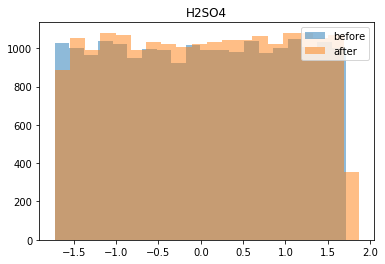

In [12]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(X_train[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(Y_train[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

# React one more step

In [13]:
%time y2_list = kpp.onestep(np.c_[y1_list, y0_list[:,-1:]].T).T  # use the same SUN as y0
y2_list.shape

CPU times: user 7.1 s, sys: 4 ms, total: 7.1 s
Wall time: 7.08 s


(20000, 74)

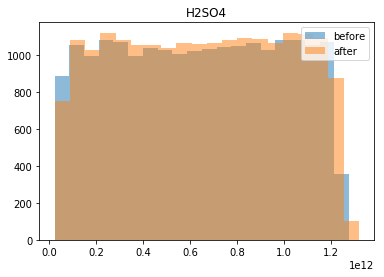

In [14]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

# Re-normalize data

In [15]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:74])

X_train = np.append(normalizer.transform(y1_list[:,0:74]), 
                    y0_list[:,-1:],  # use old SUN !
                    axis=1)
Y_train = normalizer.transform(y2_list)

# Fit ANN

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
x_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_torch = torch.tensor(Y_train, dtype=torch.float32).to(device)

In [36]:
H1, H2 = 200, 200

torch.manual_seed(7) # reproducible

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    torch.nn.Linear(H1, H2),
    torch.nn.Tanh(),
    torch.nn.Linear(H2, 74)
).to(device)

In [37]:
list(model.parameters())[0]

Parameter containing:
tensor([[ 0.0081, -0.0696,  0.0368,  ...,  0.0632, -0.0633, -0.0271],
        [ 0.1089,  0.0213,  0.0081,  ..., -0.0062,  0.0954,  0.0040],
        [-0.0297, -0.1128, -0.1062,  ..., -0.0675,  0.0017,  0.0252],
        ...,
        [ 0.0975,  0.0947, -0.0608,  ...,  0.0942,  0.0094, -0.0410],
        [ 0.0993,  0.0867, -0.0633,  ..., -0.0578, -0.0500,  0.0252],
        [-0.0034, -0.0813, -0.0826,  ...,  0.0353,  0.1135, -0.0712]], device='cuda:0')

In [38]:
%%time
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for t in range(600):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.item())

20 0.004814480897039175
40 0.0027863336727023125
60 0.0020931425970047712
80 0.0017220681766048074
100 0.0014757629251107574
120 0.001302843913435936
140 0.001175701036117971
160 0.0010773212416097522
180 0.000997183145955205
200 0.0009326856234110892
220 0.0008793078595772386
240 0.0008342154906131327
260 0.0007938506896607578
280 0.000757565547246486
300 0.0007273956434801221
320 0.0007002216880209744
340 0.0006755546201020479
360 0.0006536967703141272
380 0.0006339551182463765
400 0.0006159076583571732
420 0.000598474289290607
440 0.0005827686982229352
460 0.0005680450703948736
480 0.0005544972373172641
500 0.0005418931832537055
520 0.0005302712670527399
540 0.0005192477838136256
560 0.0005085471784695983
580 0.0004983859253115952
600 0.0004886896349489689
CPU times: user 7min 34s, sys: 1min 17s, total: 8min 51s
Wall time: 8min 51s


In [39]:
list(model.parameters())[0]

Parameter containing:
tensor([[-2.4352e-03, -4.0181e-03, -4.0804e-03,  ...,  2.6714e-02,
         -4.7602e-02,  5.0626e-02],
        [ 1.5043e-04,  1.5589e-04, -5.7094e-05,  ...,  1.0584e-03,
         -2.9739e-02, -4.5840e-01],
        [-4.3593e-03, -4.6564e-03, -1.1147e-02,  ...,  2.0942e-03,
          7.5349e-03,  2.4254e-02],
        ...,
        [-3.6774e-04, -9.6016e-04,  1.3600e-04,  ..., -2.1896e-02,
          3.1601e-02, -6.7046e-02],
        [ 9.7104e-03,  1.2451e-02, -6.2524e-03,  ...,  7.4435e-04,
          5.3289e-03, -5.9906e-02],
        [ 8.9143e-04,  3.9392e-04, -3.1082e-04,  ..., -2.3041e-03,
          2.3180e-02, -4.0532e-01]], device='cuda:0')

In [40]:
# save the model to disk
torch.save(model.state_dict(), 'trained_model.pt')

In [50]:
y_pred = model(x_torch)
y_pred_numpy = y_pred.detach().cpu().numpy()

In [51]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99990222, 0.99977415, 0.9999147 , 0.99992227, 0.99992086,
       0.99991696, 0.9998335 , 0.99986045, 0.99989896, 0.99988462,
       0.99990738, 0.99928991, 0.99973034, 0.99969488, 0.99960212,
       0.99953083, 0.99985023, 0.99931144, 0.99842711, 0.99988894,
       0.99988659, 0.99904021, 0.99977326, 0.9996656 , 0.99930221,
       0.9997648 , 0.99941084, 0.99884805, 0.99988714, 0.99982907,
       0.99981744, 0.99897204, 0.99777325, 0.993709  , 0.99951032,
       0.99872926, 0.99970233, 0.99964671, 0.9935226 , 0.99990721,
       0.99955336, 0.99989876, 0.99988489, 0.99972656, 0.99938828,
       0.99905442, 0.99458724, 0.99951592, 0.98243681, 0.99959517,
       0.99916615, 0.99862663, 0.99444928, 0.99947012, 0.99952101,
       0.99951284, 0.99975184, 0.99976824, 0.9995261 , 0.99987625,
       0.99968012, 0.9998795 , 0.99973697, 0.99948815, 0.999544  ,
       0.99982302, 0.99968129, 0.99975084, 0.99886745, 0.99984239,
       0.99939042, 0.99980328, 0.99974912, 0.9994199 ])

In [52]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9995687490234729

Text(0,0.5,'neural net prediction')

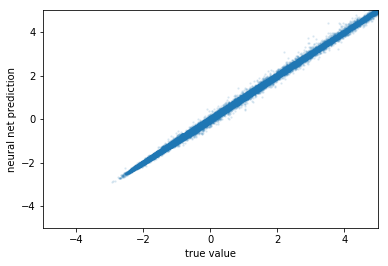

In [53]:
plt.scatter(y_pred_numpy, Y_train, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

# Test set

In [54]:
shrink = 0.0

y0_test = np.random.uniform(df_range['min'] + shrink*df_range['span'],
                           df_range['max'] - shrink*df_range['span'], 
                           size=(5000, nvar+1))

y0_test.shape

(5000, 75)

In [55]:
%%time 
y1_test = kpp.onestep(y0_test.T).T
y2_test = kpp.onestep(np.c_[y1_test, y0_test[:,-1:]].T).T  # use the same SUN as y0
y2_test.shape

CPU times: user 6.8 s, sys: 12 ms, total: 6.82 s
Wall time: 6.78 s


In [56]:
X_test = np.append(normalizer.transform(y1_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y2_test)

In [58]:
%%time
X_torch_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_pred = model(X_torch_test).detach().cpu().numpy()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.2 ms


In [59]:
r2_score(y_test_pred, Y_test, multioutput='variance_weighted')

0.9993217053350371

In [60]:
r2_score(y_test_pred, Y_test, multioutput='raw_values')

array([0.9998593 , 0.99974754, 0.99989074, 0.99990495, 0.99987436,
       0.99988893, 0.9997958 , 0.99983569, 0.99982247, 0.99986853,
       0.99988198, 0.99911742, 0.99959602, 0.99961582, 0.99946714,
       0.999424  , 0.99981134, 0.99846125, 0.99806378, 0.99985911,
       0.9998588 , 0.99894962, 0.99972489, 0.99958842, 0.99906223,
       0.99973535, 0.99926143, 0.99818788, 0.99981405, 0.99977077,
       0.99965731, 0.99876528, 0.99695685, 0.99282011, 0.99937853,
       0.99847961, 0.99953271, 0.99953559, 0.99024071, 0.99988466,
       0.99941946, 0.9998357 , 0.9998106 , 0.99953207, 0.99919972,
       0.99831072, 0.9898193 , 0.99901315, 0.94065459, 0.99951386,
       0.99893185, 0.99841941, 0.98194817, 0.99933361, 0.99937685,
       0.99939234, 0.99949141, 0.99972855, 0.99947068, 0.99982156,
       0.99956462, 0.99986263, 0.99971182, 0.99851638, 0.99907716,
       0.99972013, 0.99931541, 0.99958547, 0.99853619, 0.99979418,
       0.99880983, 0.99966228, 0.99961521, 0.99933191])

Text(0,0.5,'neural net prediction')

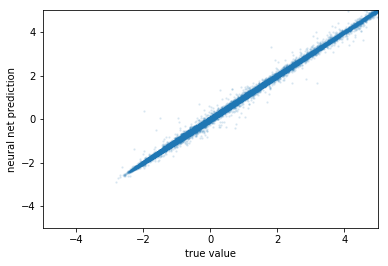

In [61]:
plt.scatter(y_test_pred, Y_test, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

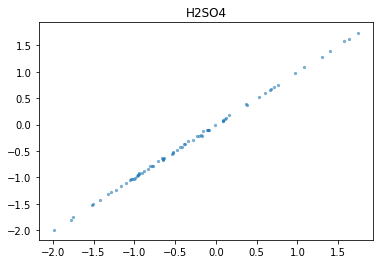

In [62]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred[n,:], Y_test[n,:], 
                alpha=0.5, s=5.0)
    plt.title(varnames[n])

# Scale back to original concentration

In [63]:
y_test_pred_scale_back = normalizer.inverse_transform(y_test_pred)
y_test_scale_back = normalizer.inverse_transform(Y_test)

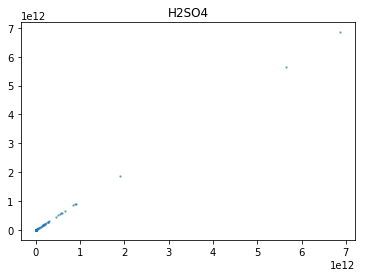

In [64]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred_scale_back[n,:], 
                y_test_scale_back[n,:], 
                alpha=0.5, s=2.0)
    plt.title(varnames[n])